# Generative models

There small world of modelling has two inputs: the data, and the model.
The models go by various names including likelihood functions and generative models but they have a a common set of properties.
- given a data point, the model will produce an estimate of the plausability of a parameter
- given a parameter, the model can produce a new data point

And therefore given a distribution for that parameter (the prior), the model will produce a full sampling distribution.

We use _plausability_ interchangeably with probability but we mean that we consider a particular value of a parameters more likely if there are more ways for the observed data to give rise to that parameter. In other words, the model is a counting machine. For any data point, it counts up the number of ways a particular hypothesis might arise. For a hypothesis, it can generate new data items. These processes are stochastic rather than deterministic in that within the model there is uncertainty about how one thing will lead to another. Nonetheless, we are explicit about the exact form of that uncertainty.

In [1]:
from collections import Counter
import numpy as np
import polars as pl
import polars.selectors as cs
from pprint import pprint
import matplotlib.pyplot as plt

from lets_plot import *
LetsPlot.setup_html()

Better to consider this dice a 'machine' with a knob that controls its lethality.
Then
- given a data point, we can estimate the plausibility of each setting of the knob
- given the knob is adjusted to a particular value, we can simulate a data point.

Three things that we need to to drive the Bayesian engine
- a prior: a mapping of an unknown variable (parameter) to a probability distribution
- the likelihood: a function that maps data to a probability; that is given an observation then how likely are the different hypothesised parameter values

The likelihood is driven by an engine that can run forwards or in reverse.
- running forwards (as the likelihood function) then it proposes representative parameters for the data that it sees
- running backwards (as a generative function) then it proposes representative data for the parameter that is chosen

Crucially, the engine is not deterministic, there is an element of randomness.
This means that we can't know what it will do exactly, but we can say something about what we would expect to see, and what would surprise us.

The machine is driven by a story. Good stories require scientific insight.
Stories are models. They are never _true_, but sometimes they are useful.

For the pandemic example, we only know that death is uncertain after an infection.
For now, all we want to know is how bad that virus is, or how likely is someone to die after an infection.
We don't yet consider a persons's prior health, or their medical care so to the model all persons and all infections are identical.

We represent this as a simple machine driven by a dice roll, starting with a ten-sided dice, and the virus has only 11 levels of lethality from $0 \dots 10$.[^a]

Running example, we use an ten-sided dice (D10) to represent the chance of death after infection with a new virus. A patient needs a roll higher than some threshold to survive. The threshold for death is unknown but can take any of eleven values $0,1,2,3,4,5,6,7,8,9,10$. That is if the threshold is $7$, then you must roll $8,9,10$ to survive. If the threshold is $0$, the patient always survives. If the threshold is $10$, the patient always dies. 

We call the threshold parameter _lethality_. And that is what we seek to learn from the observed data.

[^a]: Be mindful that lethality of the virus is not the same as the dice. To be concrete, the lethality might be $0$ but there is no $0$ on the dice (only $1 \dots 10$). The dice is a physical representation of the randomness our model contains, and the lethality is the rule applied to convert that randomness into an outcome (_die_ or _survive_)

In [2]:
n_sides = 10
lethality = pl.DataFrame({
    "hypotheses": np.arange(start=0, stop=n_sides + 1, step=1),
    "prior": 1/ (n_sides+1)
    
})
pprint(lethality)

shape: (11, 2)
┌────────────┬──────────┐
│ hypotheses ┆ prior    │
│ ---        ┆ ---      │
│ i64        ┆ f64      │
╞════════════╪══════════╡
│ 0          ┆ 0.090909 │
│ 1          ┆ 0.090909 │
│ 2          ┆ 0.090909 │
│ 3          ┆ 0.090909 │
│ …          ┆ …        │
│ 7          ┆ 0.090909 │
│ 8          ┆ 0.090909 │
│ 9          ┆ 0.090909 │
│ 10         ┆ 0.090909 │
└────────────┴──────────┘


In [3]:
(ggplot(
    lethality.with_columns(ymin=pl.lit(0)), 
    aes(x="hypotheses", ymax="prior", ymin="ymin")) 
    + geom_linerange() 
    + ggtitle("Prior distribution", "A uniform or flat prior over a probability mass (discrete) function")
 ) 


Our prior says that we have find any lethality from 0% to 100% equally plausible. If you disagree then you simply adjust your prior (ensuring that the total probability sums to $1$ 

We take our observations, and want to know how lethal the virus is.

In [4]:
# A polars data frame containing the first three observations where "D" is death and "S" is survived
data = pl.DataFrame(
    {
        "observations": list("DDS")
    }
)
pprint(data)


shape: (3, 1)
┌──────────────┐
│ observations │
│ ---          │
│ str          │
╞══════════════╡
│ D            │
│ D            │
│ S            │
└──────────────┘


So now we need to code up the two versions of the machine.
- the generative model: that produces representative (or likely) data for any particular hypothesis
- the likelihood model: that produces representative (or likely) hypotheses for any particular data point

In [5]:
def likely_data(lethality: int, dice_sides: int = 10):
    """
    The generative version of the machine
    (by brute force, just randomly sampling from a list of sides)
    Return D (died) or "S" survived from a dice roll
    """
    assert lethality <= dice_sides
    # make your dice (simply a list from 1 to 10)
    # NB stop=dice_sides+1 because Python np.arange excludes the upper bound 
    # not because the dice has 11 sides

    # =========================================================================
    # The machine ... nothing more than a simple dice used to generate data
    # =========================================================================
    dice = np.arange(start=1, stop=dice_sides + 1, step=1)
    # roll the dice
    side_rolled = np.random.choice(dice)
    # =========================================================================


    return "D" if side_rolled <= lethality else "S" 

In [6]:

assert likely_data(lethality=0) == "S"
assert likely_data(lethality=10) == "D"

from pprint import pprint
pprint([likely_data(lethality=8) for _ in range(10)])

['D', 'D', 'D', 'S', 'D', 'D', 'S', 'S', 'D', 'D']


In [7]:
def likely_hypotheses(data, dice_sides: int = 10):
    """
    The likelihood version of the machine
    Given data, evaluates the plausabilty of each hypothesis
    
    Returns a data frame with one row per hypothesised lethality
    and the number of ways that hypothesis could lead to the observated data
    """
    # Check that you're dealing with a string like "DSDDS" or similar
    data = list(data.upper())
    for datum in data:
        assert datum in ["D", "S"]
    
    # generate a different hypothetical dice for each hypothesised lethality
    # aka Loop through the lethality values
    minimum_lethality = 0
    maximum_lethality = dice_sides + 1 
    
    hypotheses = pl.DataFrame({
        "lethality": pl.arange(minimum_lethality, maximum_lethality, eager=True)
    })
    
    # This loop creates the different dice ... 
    # "the modeling engine" that drives both the generative 
    # and the likelihood model
    # =========================================================================
    # The hypothesised machine(s)
    # =========================================================================
    hypothesised_dice = []
    for lethality in hypotheses["lethality"]:
        dice = lethality * "D" + (dice_sides - lethality) * "S"
        hypothesised_dice.append(dice)
    # =========================================================================
        
    # append the dice to the dataframe
    hypotheses = hypotheses.with_columns(pl.Series("dice", hypothesised_dice))
    
    # loop through each observed value and assess how likely each hypothesised dice might produce that value
    for i, datum in enumerate(data):
        fork = f"fork{i}"
        hypotheses = hypotheses.with_columns(
            (pl.col("lethality") if datum == "D" else dice_sides - pl.col("lethality")
        ).alias(fork))
        
    hypotheses = hypotheses.with_columns(
        (hypotheses.select(cs.starts_with("fork")).fold(lambda a, b: a*b)
         ).alias("paths")
    )
    
    hypotheses = hypotheses.with_columns(
        (pl.col("paths") / pl.col("paths").sum()
         ).alias("probability")
    )
        
    
    return hypotheses
    
   

In [8]:
res = likely_hypotheses("DDS")
print(res)

# print(res.select("lethality", "dice", "paths", "probability"))

shape: (11, 7)
┌───────────┬────────────┬───────┬───────┬───────┬───────┬─────────────┐
│ lethality ┆ dice       ┆ fork0 ┆ fork1 ┆ fork2 ┆ paths ┆ probability │
│ ---       ┆ ---        ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---         │
│ i64       ┆ str        ┆ i64   ┆ i64   ┆ i64   ┆ i64   ┆ f64         │
╞═══════════╪════════════╪═══════╪═══════╪═══════╪═══════╪═════════════╡
│ 0         ┆ SSSSSSSSSS ┆ 0     ┆ 0     ┆ 10    ┆ 0     ┆ 0.0         │
│ 1         ┆ DSSSSSSSSS ┆ 1     ┆ 1     ┆ 9     ┆ 9     ┆ 0.010909    │
│ 2         ┆ DDSSSSSSSS ┆ 2     ┆ 2     ┆ 8     ┆ 32    ┆ 0.038788    │
│ 3         ┆ DDDSSSSSSS ┆ 3     ┆ 3     ┆ 7     ┆ 63    ┆ 0.076364    │
│ …         ┆ …          ┆ …     ┆ …     ┆ …     ┆ …     ┆ …           │
│ 7         ┆ DDDDDDDSSS ┆ 7     ┆ 7     ┆ 3     ┆ 147   ┆ 0.178182    │
│ 8         ┆ DDDDDDDDSS ┆ 8     ┆ 8     ┆ 2     ┆ 128   ┆ 0.155152    │
│ 9         ┆ DDDDDDDDDS ┆ 9     ┆ 9     ┆ 1     ┆ 81    ┆ 0.098182    │
│ 10        ┆ DDDDDDDDDD ┆ 10    ┆ 1

Let's animate the learning process. We are going to fix the lethality of the virus (any result up to and including $6$ on a $10$ sided dice), and then roll the dice $20\times$ and count the number of 'deaths' (rolls less than $6$), and inspect the number of ways each hypothesised dice could produce those data. We'll repeat this 500 times meaning that we'll eventually have $10,000$ data points.

In [9]:
from IPython.display import clear_output
from time import sleep

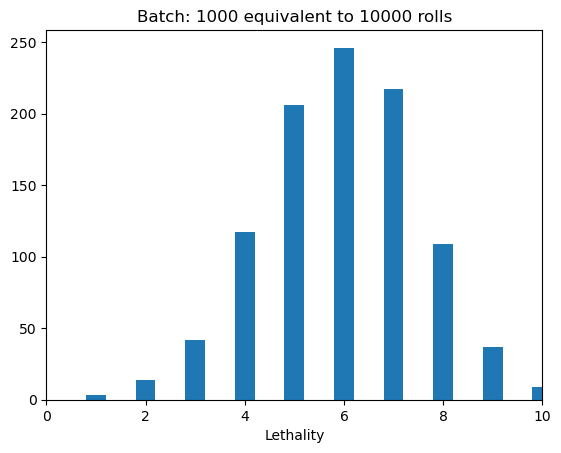

In [10]:
%matplotlib inline
interval = 0.0
samples = []
n_rolls = 10
plt.figure()
for i in range(1_000):
    rolls = [likely_data(lethality=6) for _ in range(n_rolls)]
    deaths = (np.array(rolls) == "D").sum()
    samples.append(deaths)
    # manually count use collections.Counter
    counter = Counter(samples)
    # print(counter)
    items, freq = zip(*counter.items())
    items = [item/n_rolls*10 for item in items]
    plt.bar(x=items, height=freq, width=0.4)
    plt.xlim(0,10)
    plt.xlabel("Lethality")
    plt.title(f"Batch: {len(samples)} equivalent to {n_rolls*len(samples)} rolls")
    plt.show()
    if interval:
        sleep(interval)
    clear_output(wait=True)

plt.show()


The model above is a simple counting machine. Given a data point, it counts the number of ways that survival is possible for a given lethality. We are imagining our model as different hypothesised versions of a simple machine (the dice) and that given the hypothesis (lethality), the machine tells us the number of ways that particular observation could have arisen.

:::{.callout-note}
This worked example uses a discrete probability model, and only estimates one parameter (the lethality) but the same principles apply to _all_ probability models, and any number of parameters. It just get's slower, and eventually we have to sample the posterior rather than calculate directly.
:::